# PISA Data Exploration
## by Simon Hwang

## Preliminary Wrangling
The Programme for International Student Assessment (PISA) is a means of measuring 15-year-old student ability in reading, mathematics, and science. The assessments are conducted every 3 years since 2000, and usually garner participation from about 80 countries.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
pisa = pd.read_csv('pisa2012.csv',sep=',', encoding='latin-1',error_bad_lines=False, index_col=False, dtype='str')

In [3]:
pisa.head()

,Unnamed: 0,CNT,SUBNATIO,STRATUM,OECD,NC,SCHOOLID,STIDSTD,ST01Q01,ST02Q01,...,W_FSTR75,W_FSTR76,W_FSTR77,W_FSTR78,W_FSTR79,W_FSTR80,WVARSTRR,VAR_UNIT,SENWGT_STU,VER_STU
0,1,Albania,0080000,ALB0006,Non-OECD,Albania,0000001,00001,10,1,...,13.7954,13.9235,13.1249,13.1249,4.3389,13.0829,19,1,0.2098,22NOV13
1,2,Albania,0080000,ALB0006,Non-OECD,Albania,0000001,00002,10,1,...,13.7954,13.9235,13.1249,13.1249,4.3389,13.0829,19,1,0.2098,22NOV13
2,3,Albania,0080000,ALB0006,Non-OECD,Albania,0000001,00003,9,1,...,12.7307,12.7307,12.7307,12.7307,4.2436,12.7307,19,1,0.1999,22NOV13
3,4,Albania,0080000,ALB0006,Non-OECD,Albania,0000001,00004,9,1,...,12.7307,12.7307,12.7307,12.7307,4.2436,12.7307,19,1,0.1999,22NOV13
4,5,Albania,0080000,ALB0006,Non-OECD,Albania,0000001,00005,9,1,...,12.7307,12.7307,12.7307,12.7307,4.2436,12.7307,19,1,0.1999,22NOV13


In [4]:
pisa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Columns: 636 entries, Unnamed: 0 to VER_STU
dtypes: object(636)
memory usage: 2.3+ GB


In [5]:
dic = pd.read_csv('pisadict2012.csv', encoding='latin-1')

In [6]:
dic

,Unnamed: 0,x
0,CNT,Country code 3-character
1,SUBNATIO,Adjudicated sub-region code 7-digit code (3-di...
2,STRATUM,Stratum ID 7-character (cnt + region ID + orig...
3,OECD,OECD country
4,NC,National Centre 6-digit Code
...,...,...
630,W_FSTR80,FINAL STUDENT REPLICATE BRR-FAY WEIGHT80
631,WVARSTRR,RANDOMIZED FINAL VARIANCE STRATUM (1-80)
632,VAR_UNIT,RANDOMLY ASSIGNED VARIANCE UNIT
633,SENWGT_STU,Senate weight - sum of weight within the count...


### Narrow the dataset into a subset that is simplified and easier to work with, using only OECD countries and key columns to my investigation

In [7]:
df = pisa.drop(pisa[pisa.OECD == 'Non-OECD'].index).copy()

In [8]:
df.OECD.isin(['OECD']).all()

True

In [9]:
df = df[['CNT','ST04Q01','ESCS','PV1MATH','PV2MATH','PV3MATH','PV4MATH','PV5MATH','PV1READ','PV2READ','PV3READ','PV4READ','PV5READ','PV1SCIE','PV2SCIE','PV3SCIE','PV4SCIE','PV5SCIE']]

In [10]:
df.head()

,CNT,ST04Q01,ESCS,PV1MATH,PV2MATH,PV3MATH,PV4MATH,PV5MATH,PV1READ,PV2READ,PV3READ,PV4READ,PV5READ,PV1SCIE,PV2SCIE,PV3SCIE,PV4SCIE,PV5SCIE
22151,Australia,Female,0.7,561.5439,569.3332,555.3124,578.6805,548.3019,582.3127,571.1924,602.1704,571.9867,584.6956,583.495,578.8325,592.8198,566.7102,587.2249
22152,Australia,Female,-1.17,564.8154,557.026,553.1313,538.3315,573.3837,616.7858,572.3044,559.5954,564.3613,565.1556,627.3219,600.2797,574.1701,581.63,624.5244
22153,Australia,Female,0.01,507.3298,547.0556,511.2245,454.3621,546.2767,583.9807,551.414,587.9523,575.2433,623.6962,556.1731,572.9579,584.1477,531.9284,588.8101
22154,Australia,Male,0.77,601.737,593.9477,551.885,526.1801,618.8737,649.7978,608.0967,594.4636,575.2169,620.1259,668.3514,664.6214,619.862,591.8874,656.229
22155,Australia,Male,0.8,520.1823,506.9403,500.7088,520.9612,547.4451,554.1258,559.7394,517.2363,563.7491,571.7686,573.6106,611.8426,570.8131,597.8553,662.1969


In [11]:
# check the countries that are left, and their sample sizes
df.CNT.value_counts()

Mexico                      33806
Italy                       31073
Spain                       25313
Canada                      21544
Australia                   14481
United Kingdom              12659
Switzerland                 11229
Finland                      8829
Belgium                      8597
Denmark                      7481
Chile                        6856
Japan                        6351
Slovenia                     5911
Portugal                     5722
Czech Republic               5327
Luxembourg                   5258
Greece                       5125
Israel                       5055
Korea                        5033
Ireland                      5016
Germany                      5001
United States of America     4978
Turkey                       4848
Hungary                      4810
Estonia                      4779
Austria                      4755
Sweden                       4736
Norway                       4686
Slovak Republic              4678
France        

In [12]:
# verify data completeness and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295416 entries, 22151 to 480530
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   CNT      295416 non-null  object
 1   ST04Q01  295416 non-null  object
 2   ESCS     290304 non-null  object
 3   PV1MATH  295416 non-null  object
 4   PV2MATH  295416 non-null  object
 5   PV3MATH  295416 non-null  object
 6   PV4MATH  295416 non-null  object
 7   PV5MATH  295416 non-null  object
 8   PV1READ  295416 non-null  object
 9   PV2READ  295416 non-null  object
 10  PV3READ  295416 non-null  object
 11  PV4READ  295416 non-null  object
 12  PV5READ  295416 non-null  object
 13  PV1SCIE  295416 non-null  object
 14  PV2SCIE  295416 non-null  object
 15  PV3SCIE  295416 non-null  object
 16  PV4SCIE  295416 non-null  object
 17  PV5SCIE  295416 non-null  object
dtypes: object(18)
memory usage: 42.8+ MB


In [13]:
# investigate missing ESCS values
df[df.ESCS.isna()].sample(5)

,CNT,ST04Q01,ESCS,PV1MATH,PV2MATH,PV3MATH,PV4MATH,PV5MATH,PV1READ,PV2READ,PV3READ,PV4READ,PV5READ,PV1SCIE,PV2SCIE,PV3SCIE,PV4SCIE,PV5SCIE
95086,Canada,Male,NaN,389.9439,377.4809,378.2599,467.0587,424.9961,338.3224,359.1729,404.8838,448.9908,471.4453,440.9176,432.5252,411.078,523.909,492.2044
262696,Italy,Male,NaN,405.2111,374.0536,389.6323,433.2528,411.4426,375.2118,380.0235,400.0721,402.478,408.0916,426.5573,406.0425,403.2451,493.6964,466.6542
89336,Canada,Female,NaN,340.6372,311.0375,265.0802,254.954,288.4484,448.392,423.7684,310.182,271.2608,301.4446,406.3223,423.107,339.1831,310.276,354.1029
136257,Germany,Male,NaN,498.8394,492.6079,538.5652,529.9969,496.5026,476.1767,483.3942,489.0079,483.3942,447.3067,474.3006,465.9082,506.0052,506.0052,460.3133
345552,Mexico,Male,NaN,387.7629,460.983,422.0361,452.4147,475.0039,362.3005,392.7744,383.953,358.2908,343.0538,434.2969,461.3391,410.9847,440.8243,476.2589


In [14]:
df[df.ESCS.isna()].CNT.value_counts()

Germany                     860
Canada                      457
Australia                   371
United Kingdom              292
Mexico                      208
Italy                       200
Spain                       192
Israel                      189
Belgium                     185
Denmark                     183
Japan                       166
Finland                     144
Luxembourg                  134
France                      124
Sweden                      120
Switzerland                 116
New Zealand                 114
Norway                      112
Iceland                     108
Portugal                     99
Chile                        92
Netherlands                  84
Slovenia                     78
United States of America     63
Hungary                      59
Austria                      52
Estonia                      52
Slovak Republic              49
Poland                       47
Ireland                      43
Turkey                       42
Greece  

In [15]:
# drop nan rows, as it is a problem that seems to affect most OECD countries to some degree
df.dropna(inplace=True)

In [16]:
# update data types that are numbers
for i in range(2, 18):
    df.iloc[:, i] = df.iloc[:, i].astype('float64')

In [17]:
# check dtypes are corrected
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290304 entries, 22151 to 480530
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   CNT      290304 non-null  object 
 1   ST04Q01  290304 non-null  object 
 2   ESCS     290304 non-null  float64
 3   PV1MATH  290304 non-null  float64
 4   PV2MATH  290304 non-null  float64
 5   PV3MATH  290304 non-null  float64
 6   PV4MATH  290304 non-null  float64
 7   PV5MATH  290304 non-null  float64
 8   PV1READ  290304 non-null  float64
 9   PV2READ  290304 non-null  float64
 10  PV3READ  290304 non-null  float64
 11  PV4READ  290304 non-null  float64
 12  PV5READ  290304 non-null  float64
 13  PV1SCIE  290304 non-null  float64
 14  PV2SCIE  290304 non-null  float64
 15  PV3SCIE  290304 non-null  float64
 16  PV4SCIE  290304 non-null  float64
 17  PV5SCIE  290304 non-null  float64
dtypes: float64(16), object(2)
memory usage: 42.1+ MB


In [18]:
# computer PISA scores by averaging plausible values. See readme for flaws of this approach
df['MathScore'] = df.loc[:,'PV1MATH':'PV5MATH'].mean(axis=1)
df['ReadScore'] = df.loc[:,'PV1READ':'PV5READ'].mean(axis=1)
df['ScienceScore'] = df.loc[:,'PV1SCIE':'PV5SCIE'].mean(axis=1)

In [19]:
# drop plausible value columns
df = df.iloc[:,[0, 1, 2, 18, 19, 20]]

In [20]:
df.columns = ['Country', 'Sex', 'SocioEconIndex', 'MathScore', 'ReadScore', 'ScienceScore']

In [21]:
df.head()

,Country,Sex,SocioEconIndex,MathScore,ReadScore,ScienceScore
22151,Australia,Female,0.70,562.63438,582.47156,581.81648
22152,Australia,Female,-1.17,557.33758,575.64050,601.58522
22153,Australia,Female,0.01,513.24974,584.45730,566.80344
22154,Australia,Male,0.77,578.52470,609.54018,640.19024
22155,Australia,Male,0.80,519.24754,553.32384,603.26370


### What is the structure of your dataset?

This dataset was imported as a flat file with 636 columns and 485490 rows. I have converted it into a clean, tidy subset of that file.

### What is/are the main feature(s) of interest in your dataset?
There are many possible main features of interest in this dataset, but I will focus on the scores in mathematics, reading, and science given to each student. PISA gives 5 plausible values for each knowledge area which I will average. Ordinarily, these should be weighted and replicated as per the PISA Data Analysis Manual. However, this is beyond the scope of this project, so I will be using them as is.
> Note: any relationships and conclusions may be invalid due to the discrepancy in error resulting from failing to adhere to the data wrangling steps detailed in their guidelines. See the `readme` for more information.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
The name of the country (CNT), gender of the student (ST04Q01), and the student's index of economic, social and cultural status (ESCS).

## Univariate Exploration

In [22]:
df.Country.describe()

count     290304
unique        34
top       Mexico
freq       33598
Name: Country, dtype: object

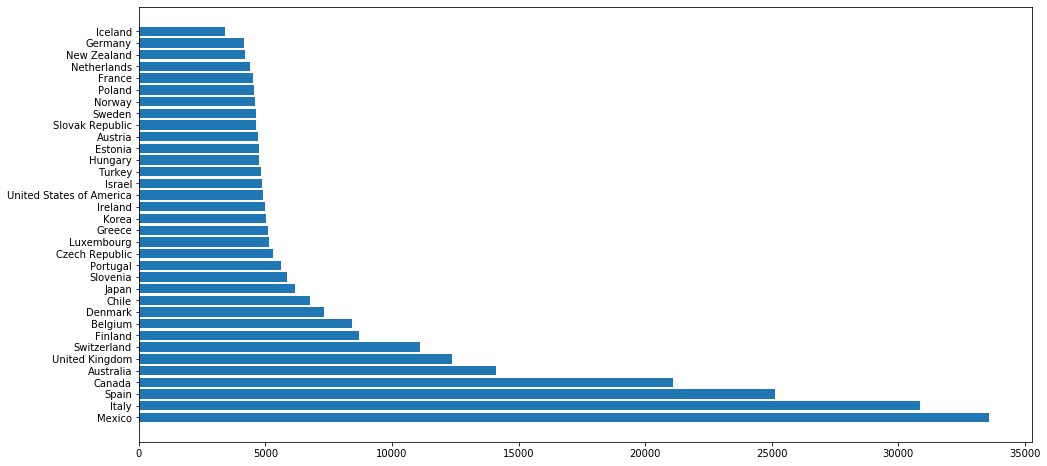

In [23]:
plt.figure(figsize=(16,8))
plt.barh(width=df.Country.value_counts(), y=df.Country.value_counts().index);

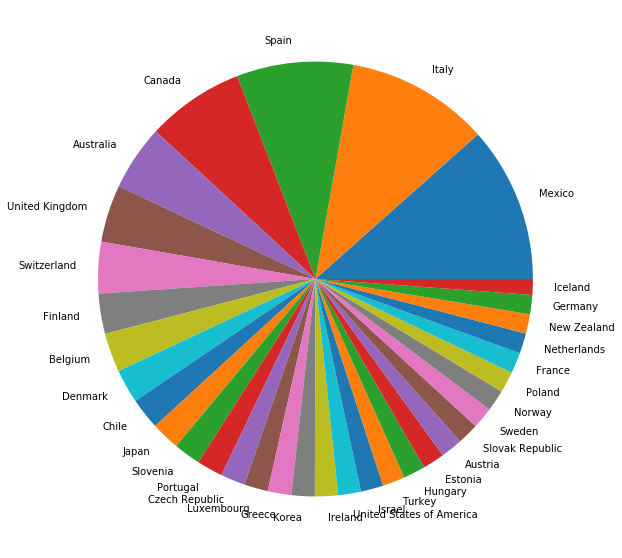

In [24]:
plt.figure(figsize=(10, 10))
plt.pie(df.Country.value_counts(), labels=df.Country.value_counts().index);

Student responses span a wide range, but do not fall far below 5000, probably because most OECD countries opt to obey PISA's __5000 students minimum requirement__. Iceland is somewhat of an outlier at the low end, but is excused due to its low population, which makes it difficult to reach 5000 even if they test every 15 year old student in the whole country. Canada, Spain, Italy, and Mexico all test well above 20000. This likely will make a good graph, with some polishing, to show off in the final report.

I also graphed a pie chart, which I think helps show how the higher sample sizes of Mexico, Italy, and Spain account for more than a quarter of the total sample. This would cause significant error, since I will not be using the PISA student weights.

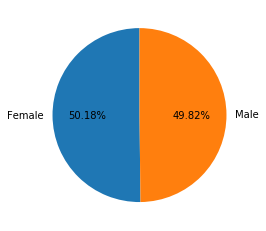

In [25]:
plt.pie(df.Sex.value_counts(), labels=df.Sex.value_counts().index, startangle=90, autopct='%1.2f%%');

The sex of students in this sample is decidedly female-biased, but it's important to note that this may be biased by those countries that test more students. This could be an interesting investigation for bivariate exploration. Also, with such an even distribution, this will make for a great categorical variable to layer on top of bivariate exploration to see multivariate relationships.

In [26]:
df.SocioEconIndex.describe()

count    290304.000000
mean         -0.061857
std           1.052444
min          -5.620000
25%          -0.760000
50%           0.000000
75%           0.760000
max           3.270000
Name: SocioEconIndex, dtype: float64

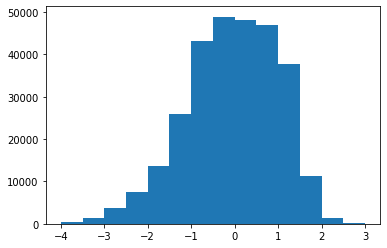

In [27]:
bins = np.arange(-4, 3.5, 0.5)
plt.hist(data=df, x='SocioEconIndex', bins=bins);
plt.xticks(np.arange(-4, 4, 1));

This looks like a pleasingly normal, unimodal distribution around 0, which makes sense given that the metric is constructed with zero being the score of an average OECD student and one being the  standard deviation across equally weighted OECD countries.

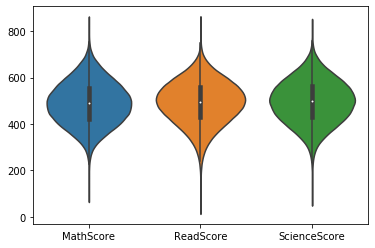

In [28]:
# graph all scores together for convenience
sb.violinplot(data=df[['MathScore','ReadScore','ScienceScore']]);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
For `Country`, the distribution of # of students sampled may appear to be logarithmic, but it's important to remember that this is a bar chart and not a histogram. I don't think a transformation would be helpful for that reason. Adding a line to indicate the 5,000 suggested minimum sample size may help. For `Sex`, there were slightly more female (50.18%) than male (49.82%) students. The remaining metrics of `SocioEconIndex`, `MathScore`, `ReadScore`, and `ScienceScore` are constructed scores that are designed to have normal distributions, so there was nothing unusual about them and did not require any transformations.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
The `Country` distribution is a bit strange due to some countries opting to test more students (see notes above), but I think showing it in both bar and pie chart forms helps clarify the discrepancies. I did perform operations on the dataset as a whole to eliminate countries with partial testing, and non-OECD countries as they tend to have more erratic results. The `SocioEconIndex` distribution had a minimum of -5.62, but I opted to start the histogram at -4 to show more detail because the y-axis scale would not even show the points below -4.

## Bivariate Exploration

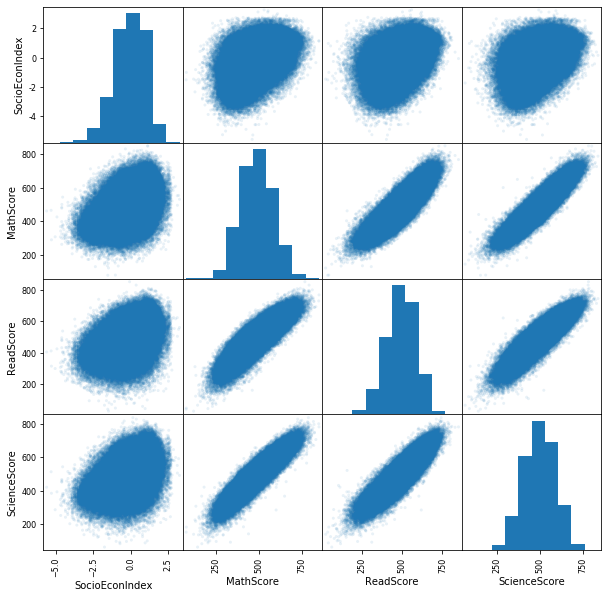

In [29]:
pd.plotting.scatter_matrix(df, figsize=(10,10), alpha=0.1);

This matrix of scatter plots shows a pretty clear positive linear correlation between the three knowledge scores, which makes intuitive sense. Students who learn better and are more intelligent tend to score higher in all categories. The `SocioEconIndex` correlation is less clear, and may warrant further investigation, which I will attempt with a heatmap, hoping that binning the values will make the overplotting less of a problem.

In [30]:
df.ScienceScore.describe()

count    290304.000000
mean        496.235826
std          92.301384
min          63.259960
25%         431.406180
50%         497.612820
75%         562.234260
max         837.877660
Name: ScienceScore, dtype: float64

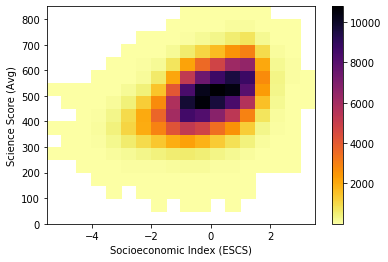

In [31]:
# since the scores are all highly correlated, I will only be plotting Science as an example
x_bin = np.arange(-5.5, df.SocioEconIndex.max()+0.5, 0.5)
y_bin = np.arange(0, df.ScienceScore.max()+50, 50)
plt.hist2d(data=df, x='SocioEconIndex', y='ScienceScore', bins=[x_bin, y_bin], cmin=0.5, cmap='inferno_r')
plt.colorbar()
plt.xlabel('Socioeconomic Index (ESCS)')
plt.ylabel('Science Score (Avg)');

This heatmap is able to cut through the enormous amount of data points and show that there is a strong positive correlation between the socioeconomic index of the student and their scores on the PISA exam.

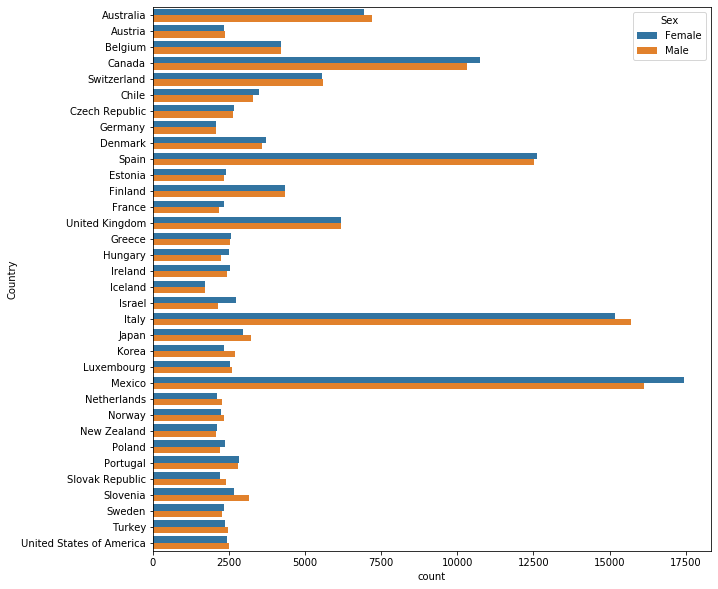

In [32]:
plt.figure(figsize=(10,10))
sb.countplot(y='Country',hue='Sex',data=df);

This plot shows there are some countries that objectively have more of one sex in their sample. However, it is a bit hard to see relatively how large-sample countries fair compared to small-sample countries. Refining this graph to show count/population would be more illuminating.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The knowledge scores interacted with each other in the exact way that one would expect: smarter kids tend to be smarter in all categories. `MathScore`, `ReadScore`, and `ScienceScore` were all clearly positively correlated with each other. Additionally, `SocioEconIndex` showed a strong, albeit weaker than those, correlation with those scores as well. This corresponds with the idea that students of higher socioeconomic standing (parental income, social class, racial privilege) tend to be better educated. The exact causal relationship of that would be interesting to examine, and is perhaps best done so by the PISA committee themselves in their own report.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Some countries (Slovenia, Korea, Mexico) had significantly more of one sex than the other in their sample. That discrepancy compared to other countries with more equal sex representation would be interesting to examine more closely, but is beyond the scope of this project.

## Multivariate Exploration

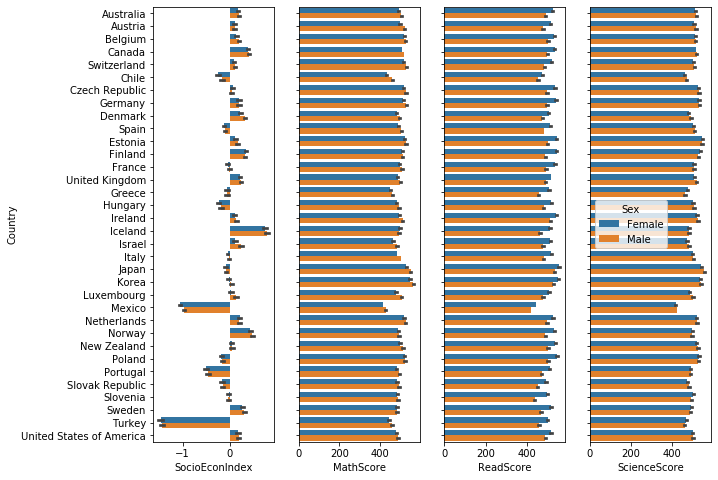

In [33]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(10,8))
sb.barplot(x='SocioEconIndex', y='Country', hue='Sex',data=df, ax=axs[0])
sb.barplot(x='MathScore', y='Country', hue='Sex',data=df, ax=axs[1])
sb.barplot(x='ReadScore', y='Country', hue='Sex',data=df, ax=axs[2])
sb.barplot(x='ScienceScore', y='Country', hue='Sex',data=df, ax=axs[3])
for i in range(0,3):
    axs[i].get_legend().remove()
for i in range(1,4):
    axs[i].label_outer();

The error bars in the above graphs should be removed in the final presentation, as it would be misleading to assume the error was calculated correctly. The two-stage sampling in PISA necessitates a different approach than a standard error calculation. At this x-scaling, it is hard to see any relationships between the four features. There is no obvious relationship between sex and the average socioeconomic index and scores of a country.

In [34]:
# focus on USA Socioeconomic Impact on Education
usa = df.query('Country == "United States of America"')
usa = usa.rename(columns={'MathScore':'Math','ReadScore':'Reading','ScienceScore':'Science'})
usa = pd.melt(usa, id_vars=['SocioEconIndex','Sex'], value_vars=['Math','Reading','Science'], var_name='Subject', value_name='Score')

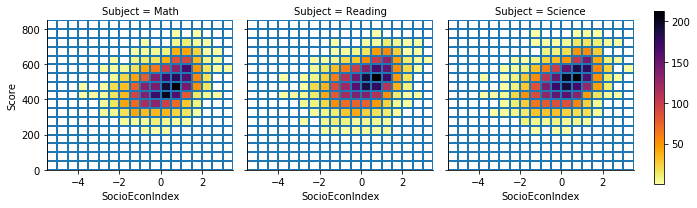

In [35]:
x_bin = np.arange(-5.5, df.SocioEconIndex.max()+0.5, 0.5)
y_bin = np.arange(0, df.ScienceScore.max()+50, 50)
g = sb.FacetGrid(data=usa, col='Subject')
g.map(plt.hist2d, 'SocioEconIndex', 'Score', bins=[x_bin, y_bin], cmin=0.5, cmap='inferno_r')
cbar_ax = g.fig.add_axes([1.015,0.13, 0.015, 0.8])
plt.colorbar(cax=cbar_ax)

For the United States of America, the relationship between socioeconomic index and any of the three subjects looks about the same. The main difference is that the science scores look to have a mode that is slightly higher math, although the previous graph had shown that the means are all about the same.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

From a global (OECD countries only) viewpoint, there did not seem to be any obvious relationships between a country's sex, socioeconomic index, and average scores on the PISA. However, looking at the United States of America as a zoom-in view, there is a clear in-country positive correlation for each of the 3 scores.

### Were there any interesting or surprising interactions between features?

At this point, there were no surprises.

In [36]:
df.to_csv('pisa_subset.csv', index=False)